In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir('/content/drive/MyDrive/Mask_RCNN')

In [3]:
!pip3 install tensorflow==1.13.1
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0
!pip install -U scikit-image==0.16.2

     |████████████████████████████████| 92.6 MB 74 kB/s 
     |████████████████████████████████| 367 kB 50.1 MB/s 
     |████████████████████████████████| 3.2 MB 33.7 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you 

In [4]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DATASET_DIRECTORY = "/content/drive/MyDrive/gitar"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [5]:

############################################################
#  Configurations
############################################################


class CustomshapeConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "customshape"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + customshape

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    
# learning rate
LEARNING_RATE = 0.001

# Number of epochs
Number_of_epochs = 30

In [6]:

############################################################
#  Dataset
############################################################

class CustomshapeDataset(utils.Dataset):

    def load_customshape(self, dataset_dir, subset):
        """Load a subset of the Customshape dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("customshape", 1, "customshape")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open('/content/drive/MyDrive/Mask_RCNN/via_region_data_train.json'))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print(dataset_dir)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "customshape",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a customshape dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "customshape":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "customshape":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [7]:


class CustomshapeDataset_val(utils.Dataset):

    def load_customshape(self, dataset_dir, subset):
        """Load a subset of the Customshape dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("customshape", 1, "customshape")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open('/content/drive/MyDrive/Mask_RCNN/via_region_data_val.json'))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print(dataset_dir)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "customshape",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a customshape dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "customshape":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "customshape":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [8]:
# train the model

def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomshapeDataset()
    dataset_train.load_customshape(DATASET_DIRECTORY, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomshapeDataset_val()
    dataset_val.load_customshape(DATASET_DIRECTORY, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=LEARNING_RATE,
                epochs=Number_of_epochs,
                layers='heads')
    
    #model.save('/content/drive/MyDrive/gitar_mask_rcnn_trained.h5')


############################################################
#  Training
############################################################


config = CustomshapeConfig()   
    # Create model
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR) 
    # Select weights file to load 
weights_path = COCO_WEIGHTS_PATH
    # Load weights
print("Loading weights ", weights_path)
    # Exclude the last layers because they require a matching
        # number of classes
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
train(model)
            

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading weights  /content/drive/MyDrive/Mask_RCNN/mask_rcnn_coco.h5
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive/MyDrive/gitar/train
/content/drive

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
 99/100 [============================>.] - ETA: 2s - loss: 1.1452 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3208 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.3066

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 392s - loss: 1.1390 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3192 - mrcnn_class_loss: 0.1491 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.3046 - val_loss: 1.1457 - val_rpn_class_loss: 0.0249 - val_rpn_bbox_loss: 0.5448 - val_mrcnn_class_loss: 0.0302 - val_mrcnn_bbox_loss: 0.3544 - val_mrcnn_mask_loss: 0.1914
Epoch 2/30
100/100 [==============================] - 303s - loss: 0.3678 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1452 - val_loss: 1.0367 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.4686 - val_mrcnn_class_loss: 0.0328 - val_mrcnn_bbox_loss: 0.3420 - val_mrcnn_mask_loss: 0.1729
Epoch 3/30
100/100 [==============================] - 301s - loss: 0.2591 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1147 - val_loss: 1.1366 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 0.

<Figure size 432x288 with 0 Axes>

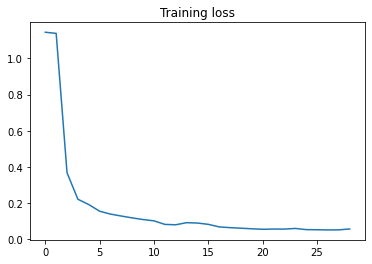

<Figure size 432x288 with 0 Axes>

In [10]:
loss_list = [1.1452 ,                  
1.1390,
0.3678,
0.2213,
0.1920,
0.1550,
0.1392,
0.1284,
0.1181,
0.1091,
0.1019,
0.0822,
0.0801,
0.0918,
0.0897,
0.0825,
0.0683,
0.0642,
0.0612,
0.0579,
0.0552,
0.0565,
0.0562,
0.0598,
0.0534,
0.0526,
0.0517,
0.0520,
0.0571
]

from matplotlib import pyplot as plt
epochs = range(len(loss_list))

# Plot training and validation accuracy per epoch
plt.plot(epochs, loss_list)
plt.title('Training loss')

plt.figure()

<Figure size 432x288 with 0 Axes>

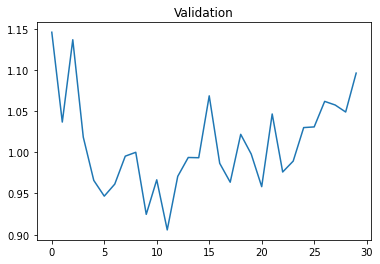

<Figure size 432x288 with 0 Axes>

In [11]:
validation_list = [1.1457,
                                                        1.0367,
                                                        1.1366,
                                                        1.0184,
                                                        0.9659,
                                                        0.9468,
                                                        0.9614,
                                                        0.9953,
                                                        1.0000,
                                                        0.9247,
                                                        0.9666,
                                                        0.9058,
                                                        0.9708,
                                                        0.9937,
                                                        0.9934,
                                                        1.0685,
                                                        0.9866,
                                                        0.9637,
                                                        1.0218,
                                                        0.9979,
                                                        0.9583,
                                                        1.0465,
                                                        0.9761,
                                                        0.9893,
                                                        1.0300,
                                                        1.0308,
                                                        1.0618,
                                                        1.0574,
                                                        1.0489,
                                                        1.0961
                                                        ]

from matplotlib import pyplot as plt
epochs = range(len(validation_list))

# Plot training and validation accuracy per epoch
plt.plot(epochs, validation_list)
plt.title('Validation')

plt.figure()